# Opposing Forces Calculation
A Heuristic to determine when two players are in a dangerous situation:
    1. Their forces are directly opposing eachother (they are moving fast in opposite directions)
    2. They are close to eachother (<2 yards away from eachother)

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import math
%matplotlib inline

## Data Prep

In [18]:
vr = pd.read_csv('../input/video_review.csv')
pprd = pd.read_csv('../input/play_player_role_data.csv')
pi = pd.read_csv('../input/play_information.csv')

vr.Primary_Partner_GSISID = vr.Primary_Partner_GSISID.fillna(0).replace('Unclear',0).astype('int64')
vr_merged = pd.merge(pd.merge(vr, pprd), pprd, left_on=['Season_Year','GameKey','PlayID','Primary_Partner_GSISID'],
                                   right_on=['Season_Year','GameKey','PlayID','GSISID'], how='left').fillna('None')

In [4]:
vr_merged.loc[(vr['Season_Year'] == 2017) &
       (vr['GameKey'] == 553)]

,Season_Year,GameKey,PlayID,GSISID_x,Player_Activity_Derived,Turnover_Related,Primary_Impact_Type,Primary_Partner_GSISID,Primary_Partner_Activity_Derived,Friendly_Fire,Role_x,GSISID_y,Role_y
30,2017,553,1683,32820,Blocking,No,Helmet-to-helmet,25503,Blocked,No,PDL2,25503,PLS


## Pivot Play and plot mph for each player through the play

In [5]:
play =pd.read_csv('../working/playlevel/during_play/2017-553-1683.csv')
play['xy'] = play['x'].astype(str) + ',' + play['y'].astype(str)
play_pivoted = play.pivot(index='time', columns='role', values=['xy','mph','dir', 'x', 'y'])
play_pivoted.columns = [' '.join(col).strip() for col in play_pivoted.columns.values]

In [6]:
mph_cols = [col for col in play_pivoted.columns if col[:3] == 'mph']

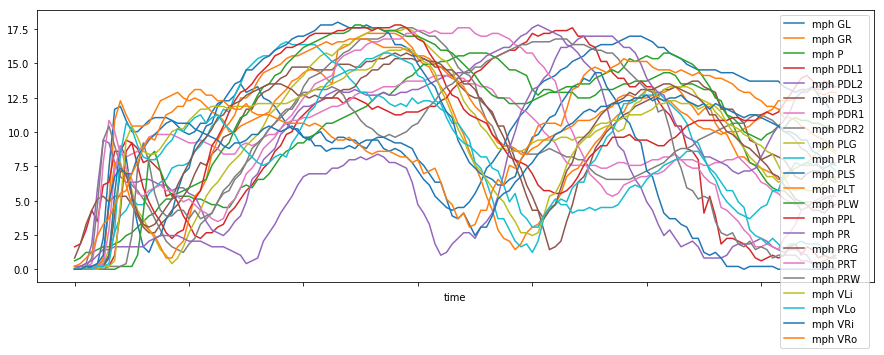

In [7]:
play_pivoted[mph_cols].plot(figsize=(15, 5))

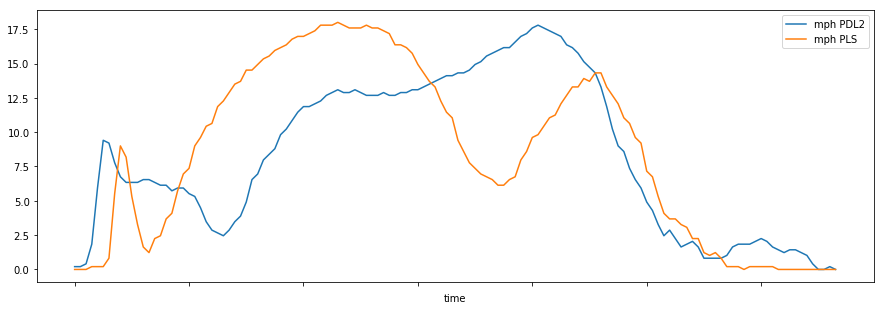

In [8]:
play_pivoted[['mph PDL2','mph PLS']].plot(figsize=(15, 5))

## Euclidian distance

In [9]:
play_pivoted['PDL2-PLS-distance'] = np.sqrt(np.square(play_pivoted['x PDL2'].astype('float') - \
                                                      play_pivoted['x PLS'].astype('float')) + \
                                            np.square(play_pivoted['y PDL2'].astype('float') - \
                                                      play_pivoted['y PLS'].astype('float')))

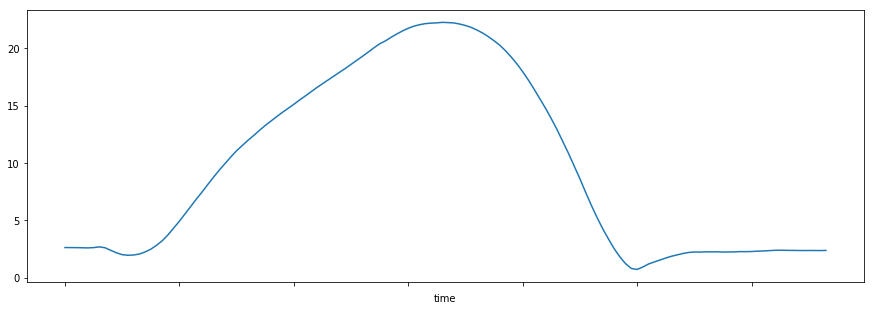

In [10]:
play_pivoted['PDL2-PLS-distance'].plot(figsize=(15, 5))

## Find the Time of the hit

In [11]:
min_distance_time = play_pivoted['PDL2-PLS-distance'].sort_values().index[0]

In [12]:
min_distance_time

'2017-11-19 19:16:21.700'

In [13]:
play_pivoted.loc[min_distance_time][['dir PDL2','dir PLS','PDL2-PLS-distance','mph PDL2', 'mph PLS']]

dir PDL2               264.42
dir PLS                 21.63
PDL2-PLS-distance    0.718471
mph PDL2              4.90909
mph PLS               7.15909
Name: 2017-11-19 19:16:21.700, dtype: object

In [22]:
import numpy as np

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [15]:
play_pivoted['PDL2_x_force'], play_pivoted['PDL2_y_force'] = pol2cart(play_pivoted['mph PDL2'].astype('float'),
                                                                      play_pivoted['dir PDL2'].astype('float') * (np.pi/ 180))
play_pivoted['PLS_x_force'], play_pivoted['PLS_y_force'] = pol2cart(play_pivoted['mph PLS'].astype('float'),
                                                                    play_pivoted['dir PLS'].astype('float') * (np.pi/ 180))

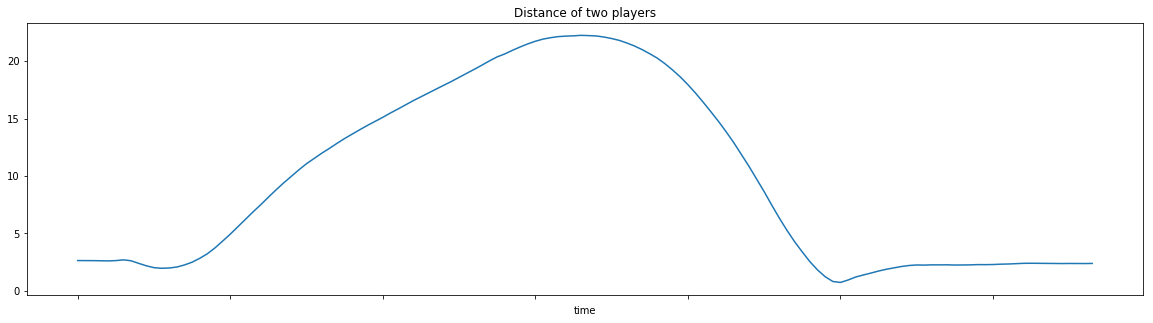

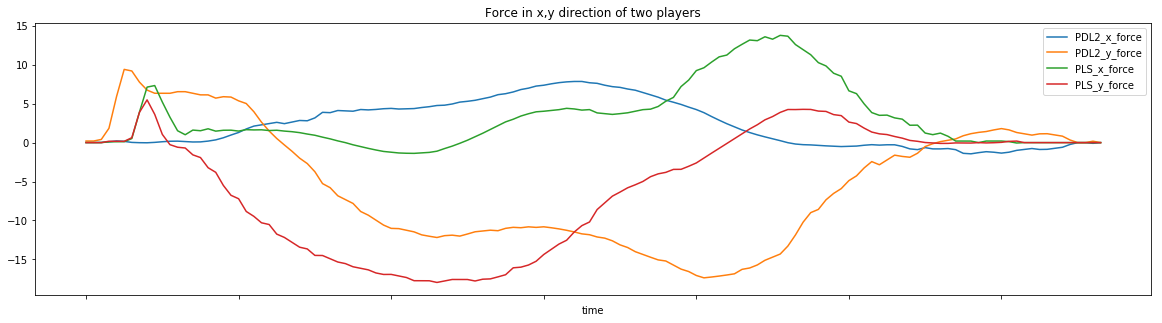

In [16]:
play_pivoted['PDL2-PLS-distance'].plot(figsize=(20, 5), title='Distance of two players')
play_pivoted[['PDL2_x_force','PDL2_y_force','PLS_x_force','PLS_y_force']].sort_index().plot(figsize=(20, 5), title='Force in x,y direction of two players')

In [17]:
play_pivoted['PLS_PDL2_Opposing_Forces'] = np.sqrt(np.square(play_pivoted['PDL2_x_force'] \
                  - play_pivoted['PLS_x_force']) + \
        np.square((play_pivoted['PDL2_y_force'] - \
                   play_pivoted['PLS_y_force'])))

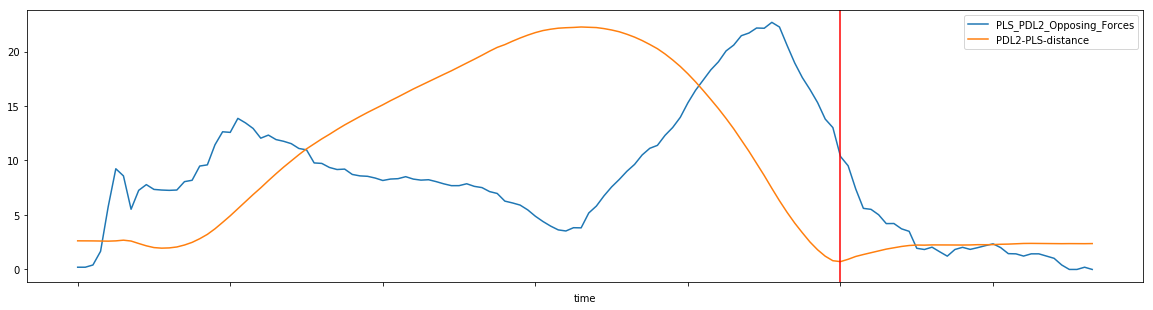

In [18]:
play_pivoted[['PLS_PDL2_Opposing_Forces','PDL2-PLS-distance']].plot(figsize=(20, 5))
plt.axvline(100, color='red')

## Try for a second play

In [42]:
def plot_opposing_forces(year, gamekey, playid, role1, role2, plot=True):
    play = pd.read_csv(
        '../working/playlevel/during_play/{}-{}-{}.csv'.format(year, gamekey, playid))
    play['xy'] = play['x'].astype(str) + ',' + play['y'].astype(str)
    play_pivoted = play.pivot(index='time', columns='role', values=[
                              'xy', 'mph', 'dir', 'x', 'y'])
    play_pivoted.columns = [' '.join(col).strip()
                            for col in play_pivoted.columns.values]
    play_pivoted['{}-{}-distance'.format(role1, role2)] = \
        np.sqrt(np.square(play_pivoted['x {}'.format(role1)].astype('float')
                          - play_pivoted['x {}'.format(role2)].astype('float'))
                + np.square(play_pivoted['y {}'.format(role1)].astype('float') \
                            - play_pivoted['y {}'.format(role2)].astype('float')))
    play_pivoted['{}_x_force'.format(role1)], play_pivoted['{}_y_force'.format(role1)] = pol2cart(
        play_pivoted['mph {}'.format(role1)].astype('float'), play_pivoted['dir {}'.format(role1)].astype('float') * (np.pi / 180))
    play_pivoted['{}_x_force'.format(role2)], play_pivoted['{}_y_force'.format(role2)] = pol2cart(
        play_pivoted['mph {}'.format(role2)].astype('float'), play_pivoted['dir {}'.format(role2)].astype('float') * (np.pi / 180))
    
    play_pivoted['{}_{}_Opposing_Forces'.format(role1, role2)] = np.sqrt(np.square(play_pivoted['{}_x_force'.format(role1)] \
                  - play_pivoted['{}_x_force'.format(role2)]) + \
        np.square((play_pivoted['{}_y_force'.format(role1)] - \
                   play_pivoted['{}_y_force'.format(role2)])))
    
    # Lookup play info and grab play description
    play_info_row = pi.loc[(pi['Season_Year'] == year) &
       (pi['GameKey'] == gamekey) &
       (pi['PlayID'] == playid)]
    play_description = play_info_row['PlayDescription'].values[0]
    
    if plot:
        play_pivoted[['{}_{}_Opposing_Forces'.format(role1, role2),
                  '{}-{}-distance'.format(role1, role2)]].plot(figsize=(20, 5), title='Season {} - GameKey {} - PlayId - {} - \n {}'.format(year,
                                                                                                                                    gamekey,
                                                                                                                                    playid,
                                                                                                                                   play_description))
    return play_pivoted

## Loop through concussion plays and plot opposing forces

In [24]:
df.loc[df['{}-{}-distance'.format(role1, role2)] < 2]['{}_{}_Opposing_Forces'.format(role1, role2)].max()

nan

3129
Max opposing force: 
20.6749822214


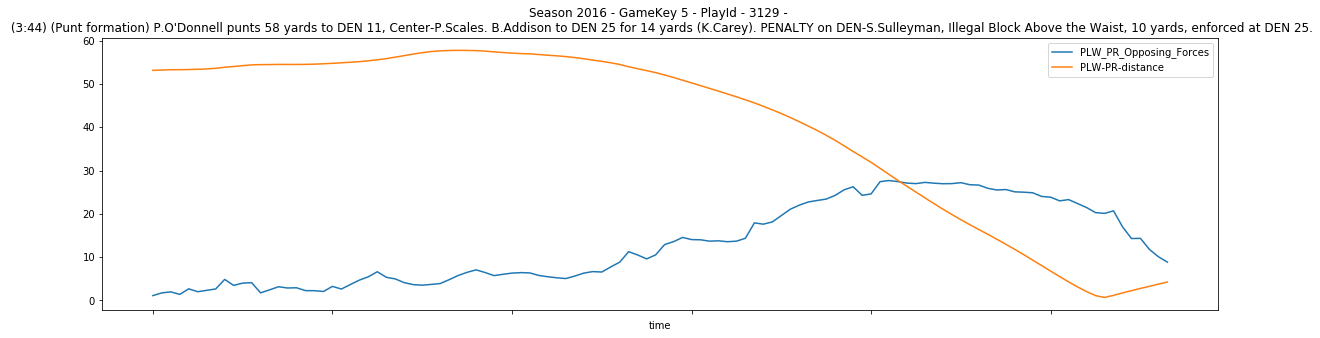

2587
Max opposing force: 
7.5317280953


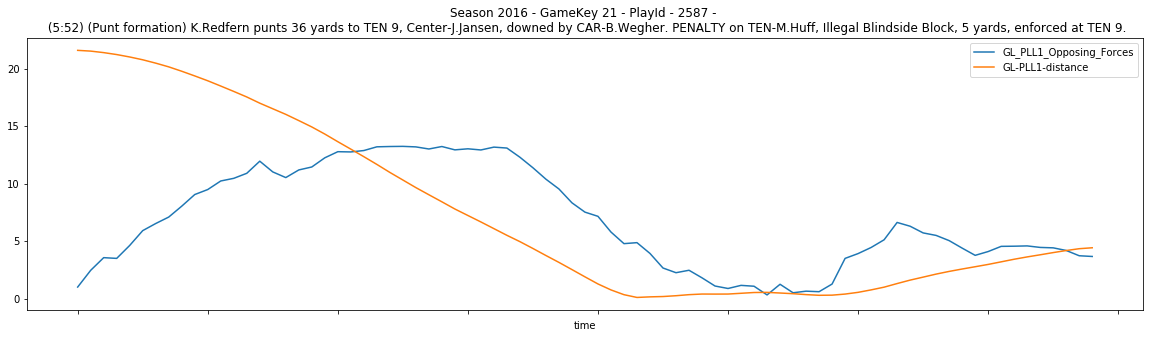

538
Max opposing force: 
26.1984382887


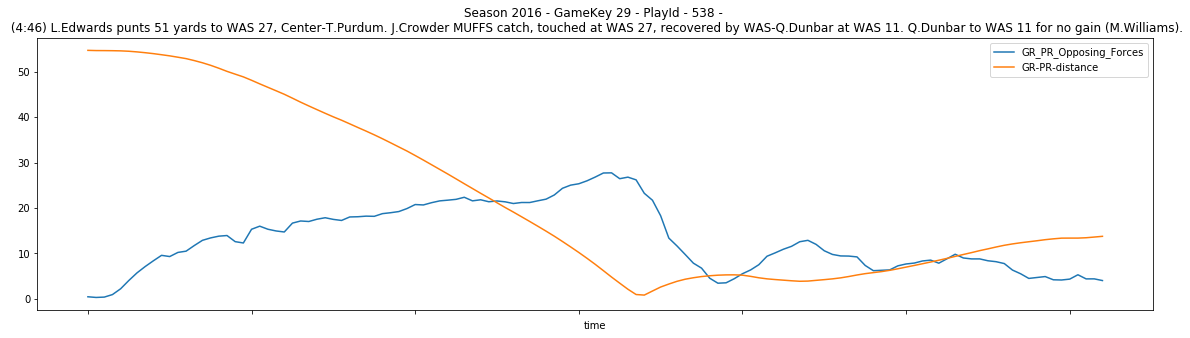

1212
Max opposing force: 
9.68129609452


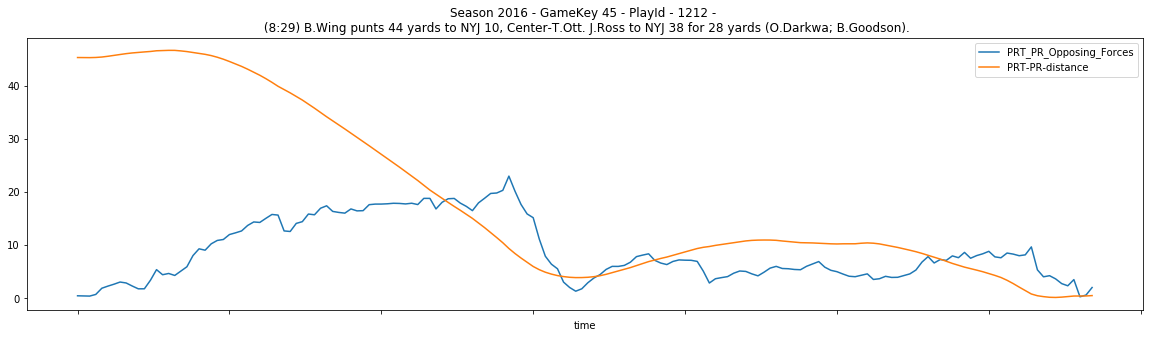

1045
Max opposing force: 
12.9885978478


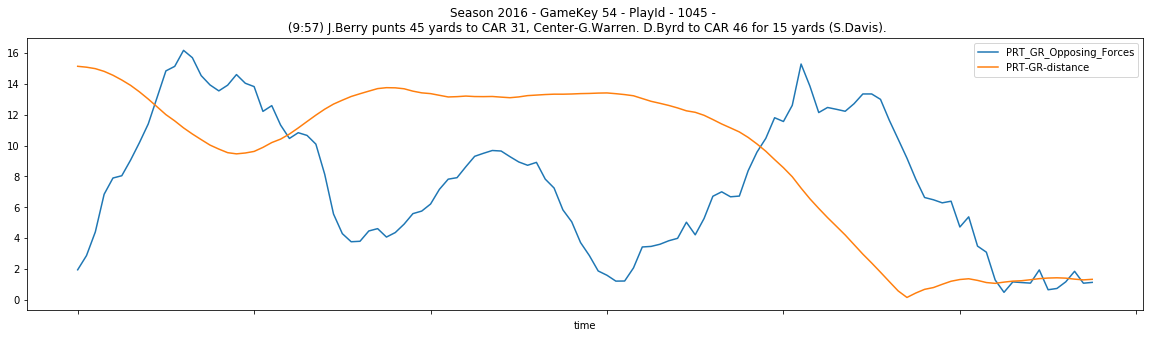

905
Max opposing force: 
8.08826470679


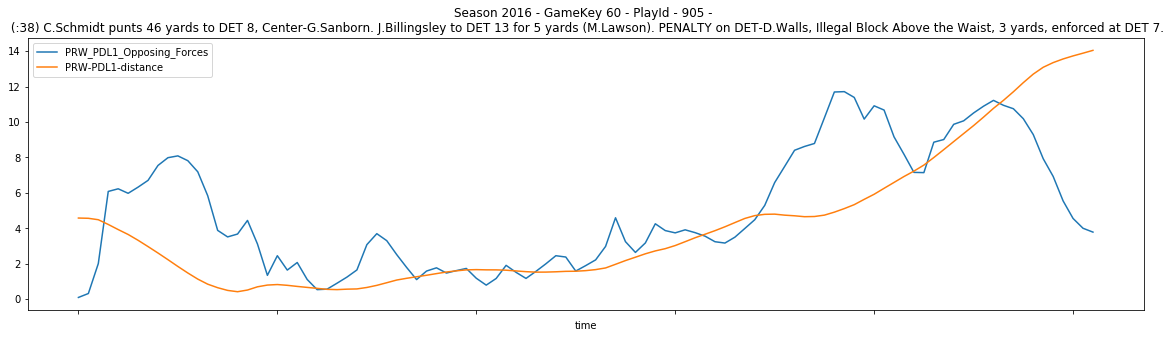

2342
Max opposing force: 
13.2646419259


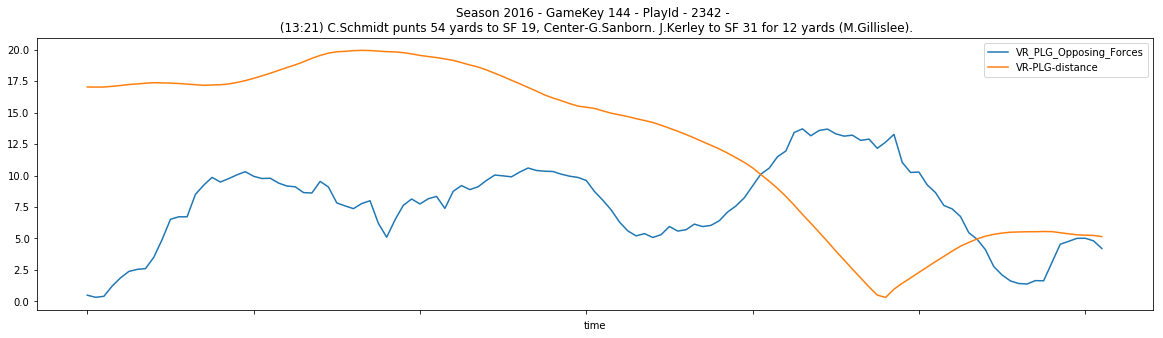

3663
Max opposing force: 
16.8931551357


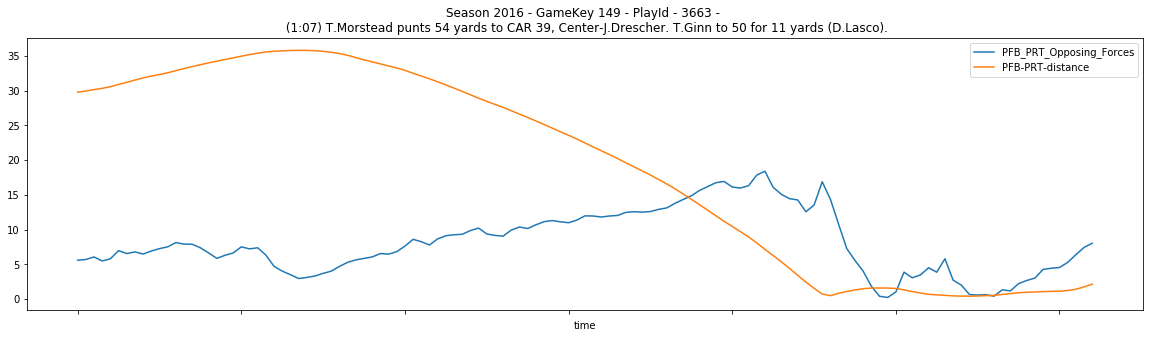

3509
Max opposing force: 
26.9373486707


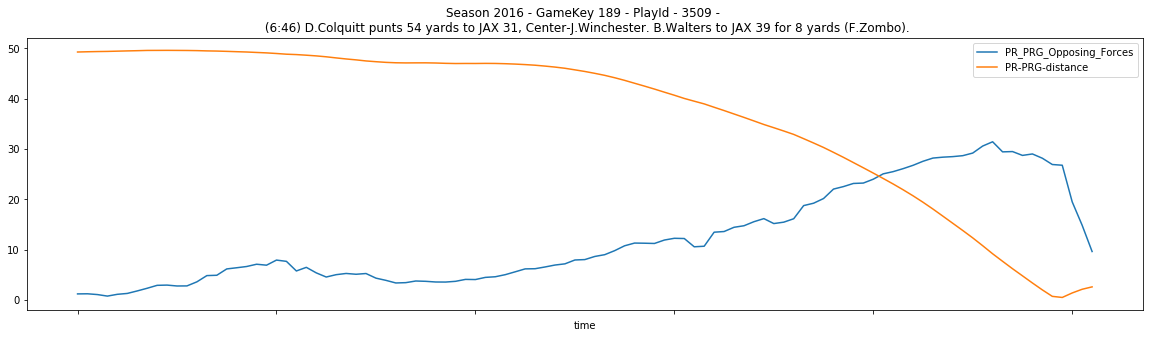

error
'x None'
1976
Max opposing force: 
7.28946438393


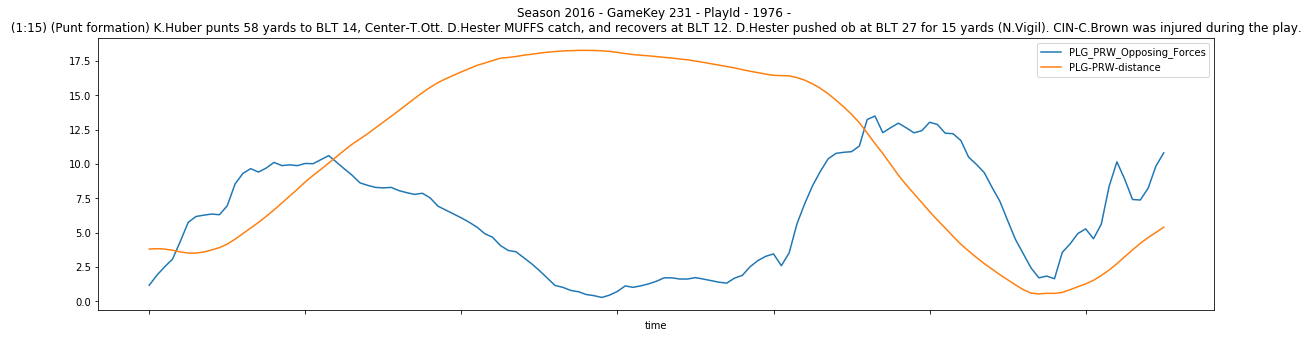

3278
Max opposing force: 
2902
Max opposing force: 
22.9089964603


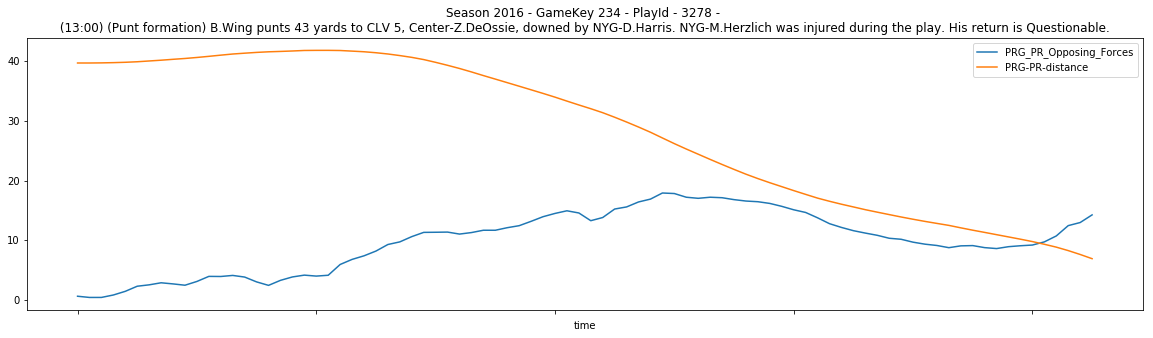

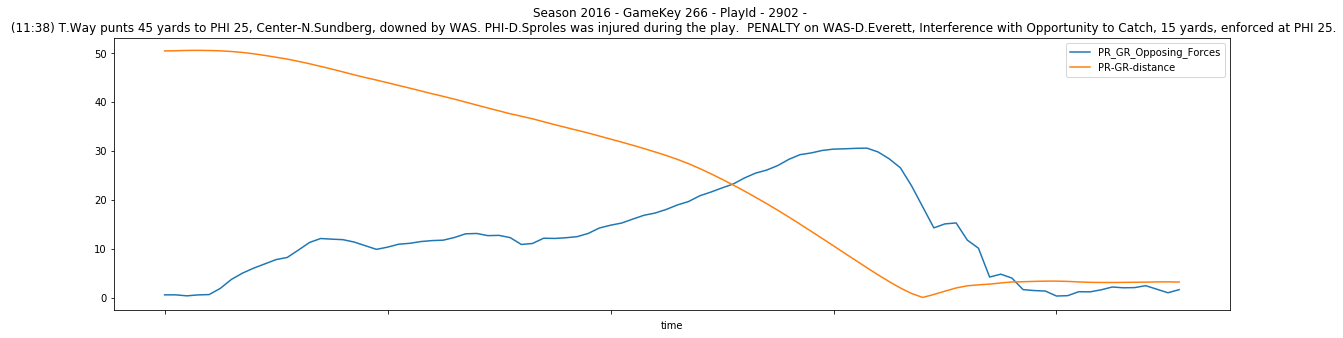

3609
Max opposing force: 
15.0520774235


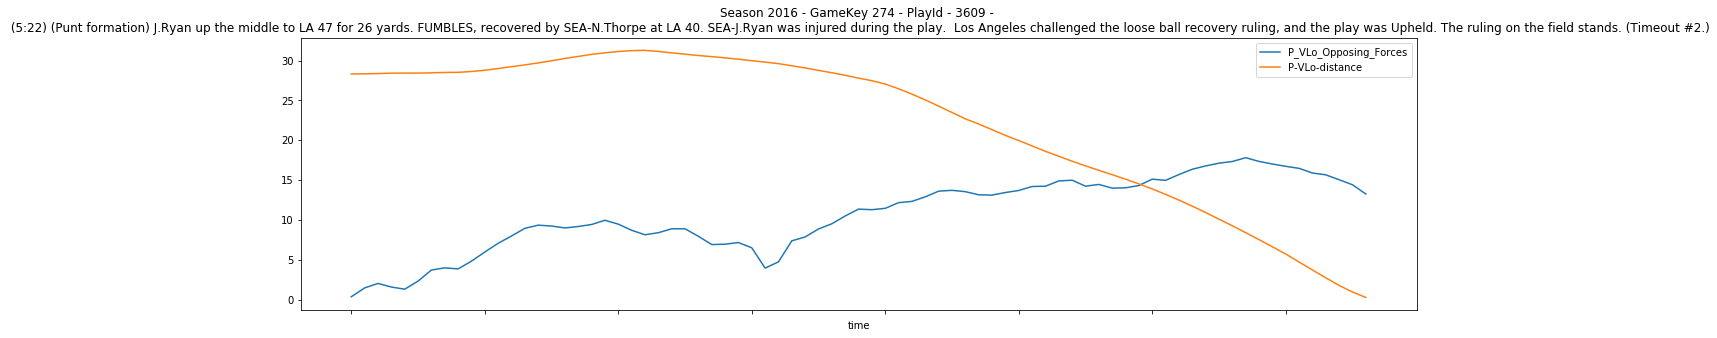

2918
Max opposing force: 
12.1423269044


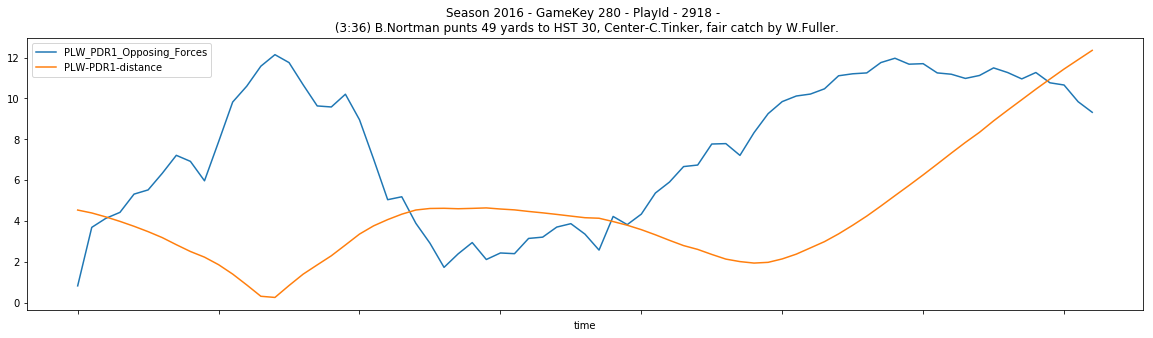

3746
Max opposing force: 
13.3644550302


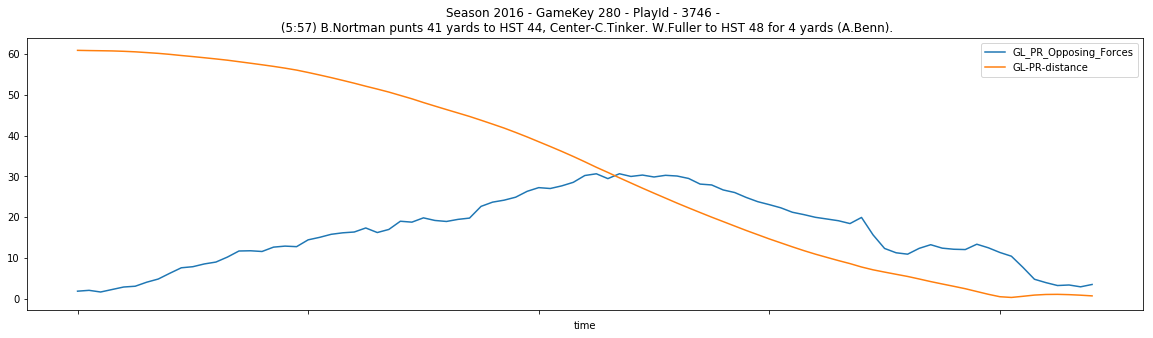

1526
Max opposing force: 
19.0330388351


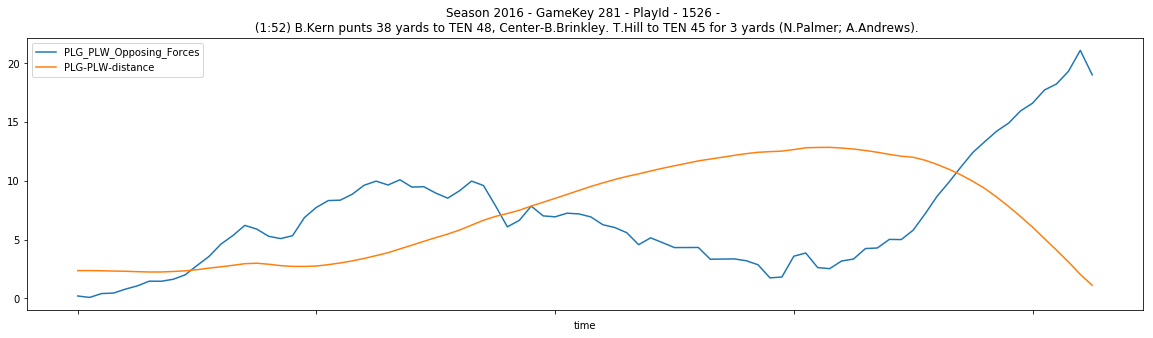

2341
Max opposing force: 
15.7116432869


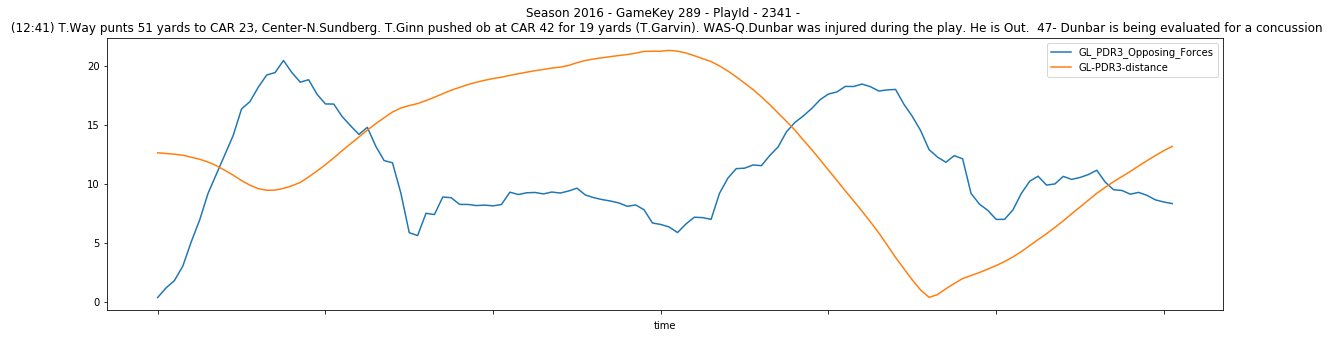

2667
Max opposing force: 
17.1384793616


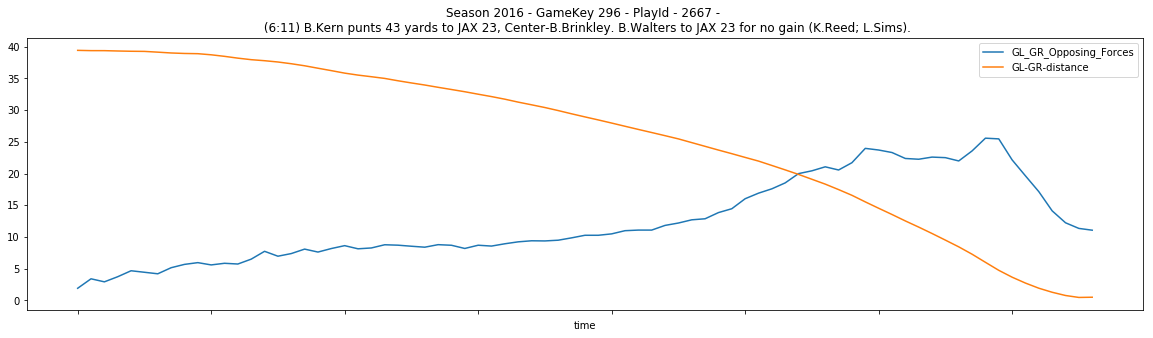

3630
Max opposing force: 
15.6176794907


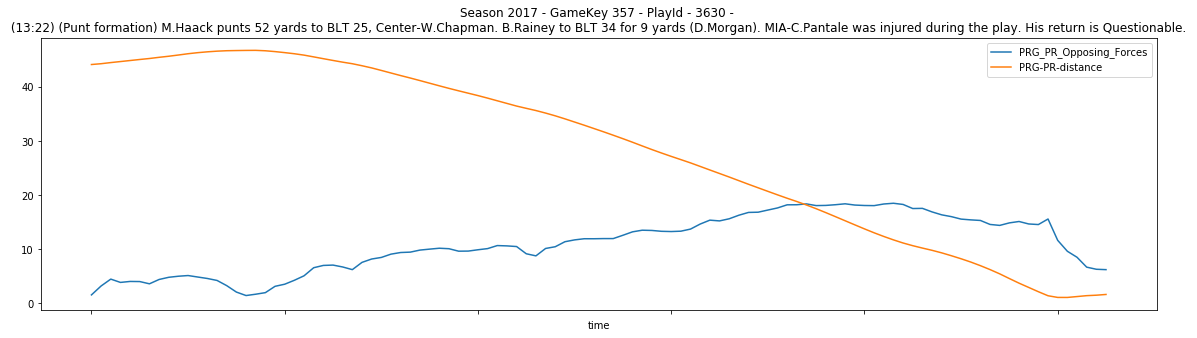

2489
Max opposing force: 
6.13738143693


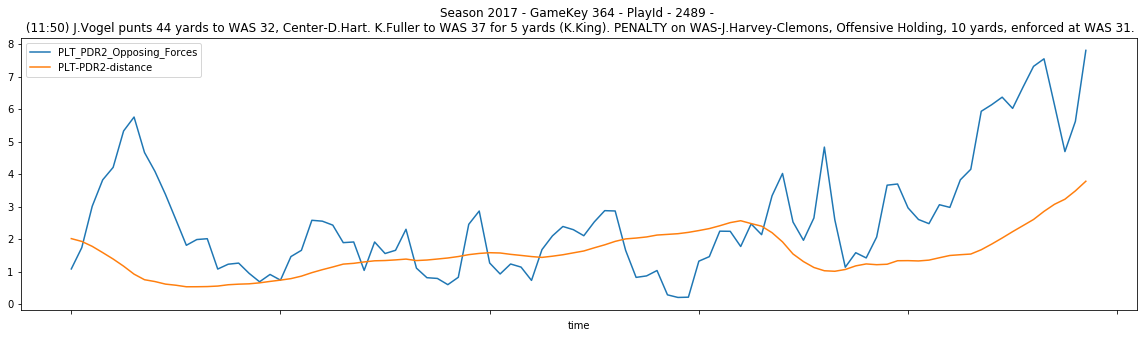

2764
Max opposing force: 
9.3300474101


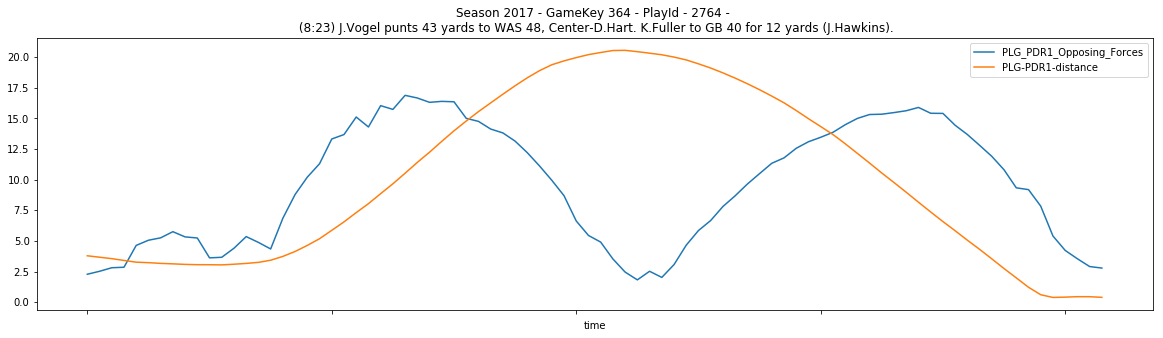

183
Max opposing force: 
1088
Max opposing force: 
10.4653539197


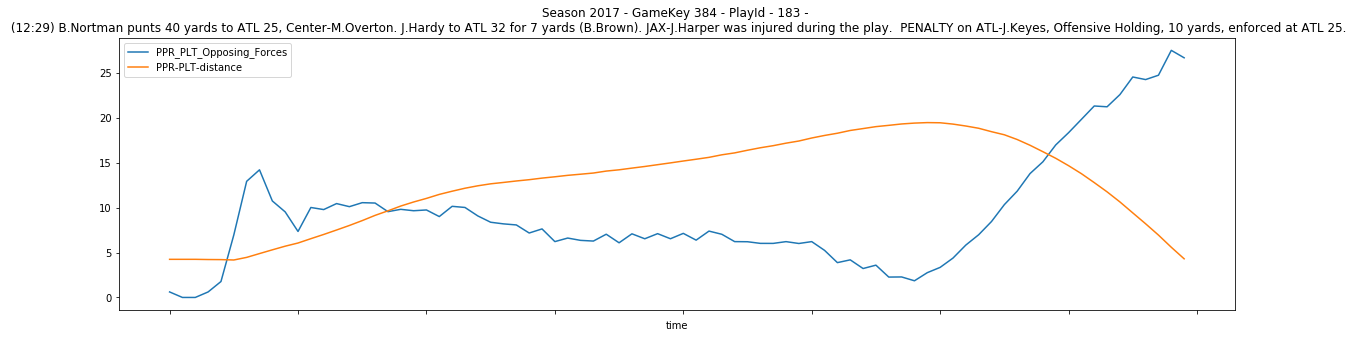

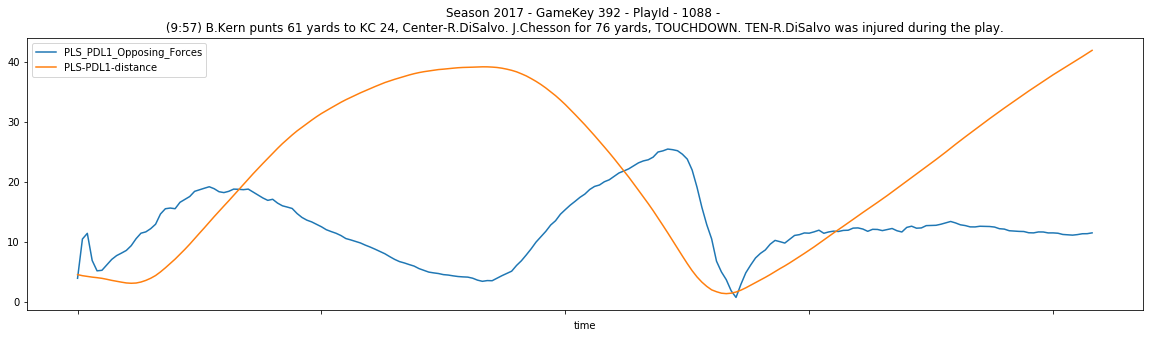

1526
Max opposing force: 
14.2667830985


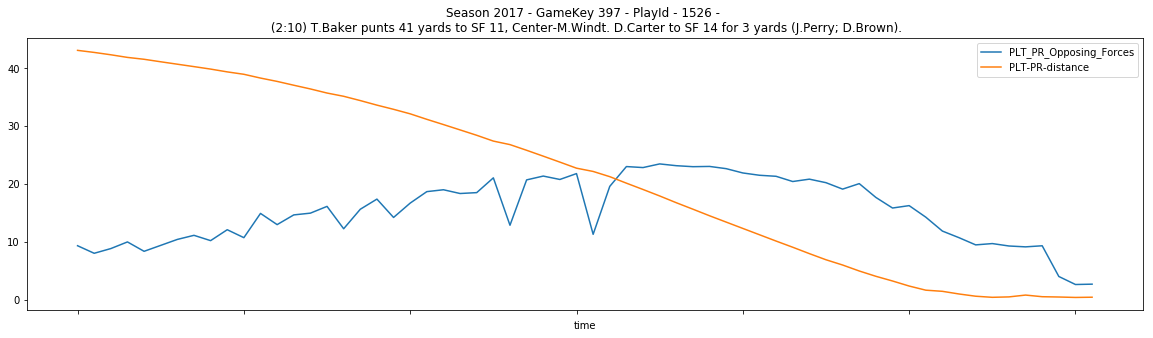

3312
Max opposing force: 
14.0994260446


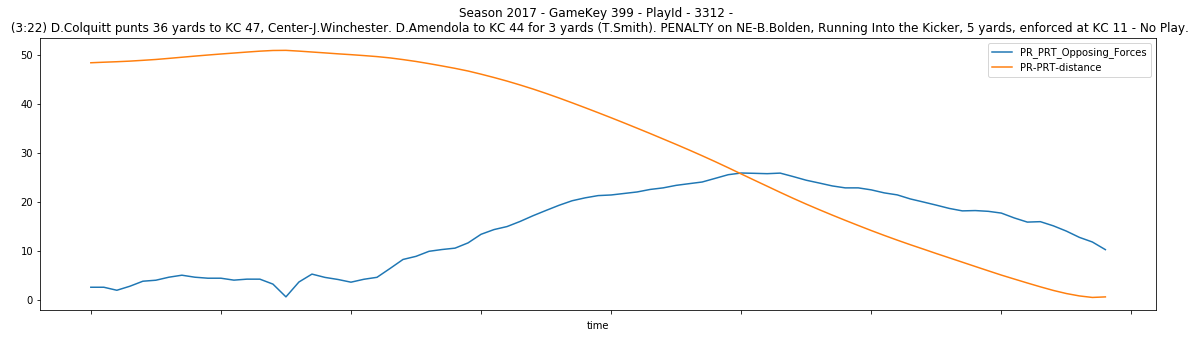

error
'x None'
2792
Max opposing force: 
14.103154558


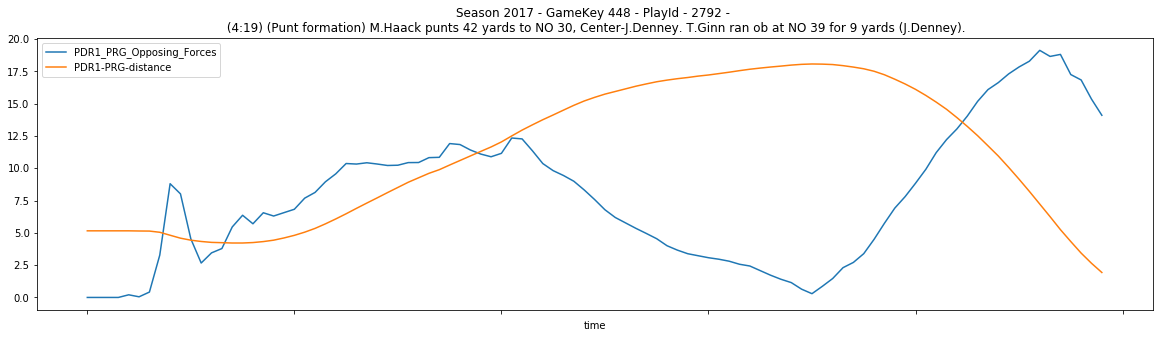

2072
Max opposing force: 
9.31519696858


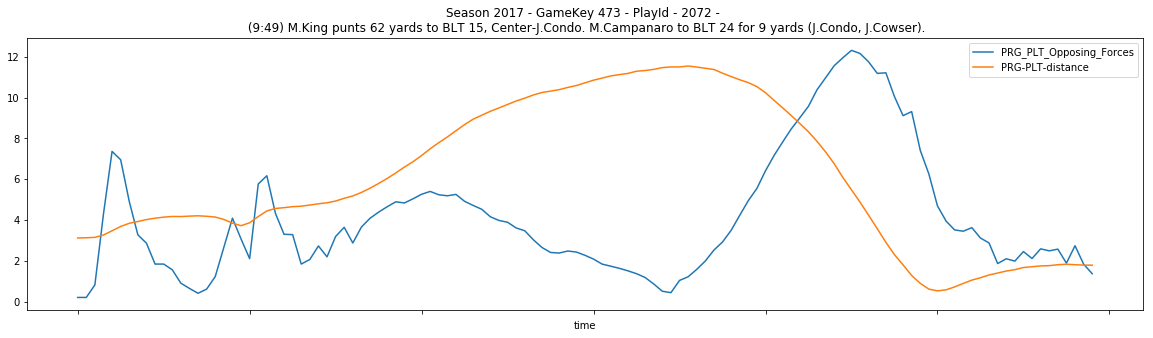

error
'x None'
1683
Max opposing force: 
15.3132730059


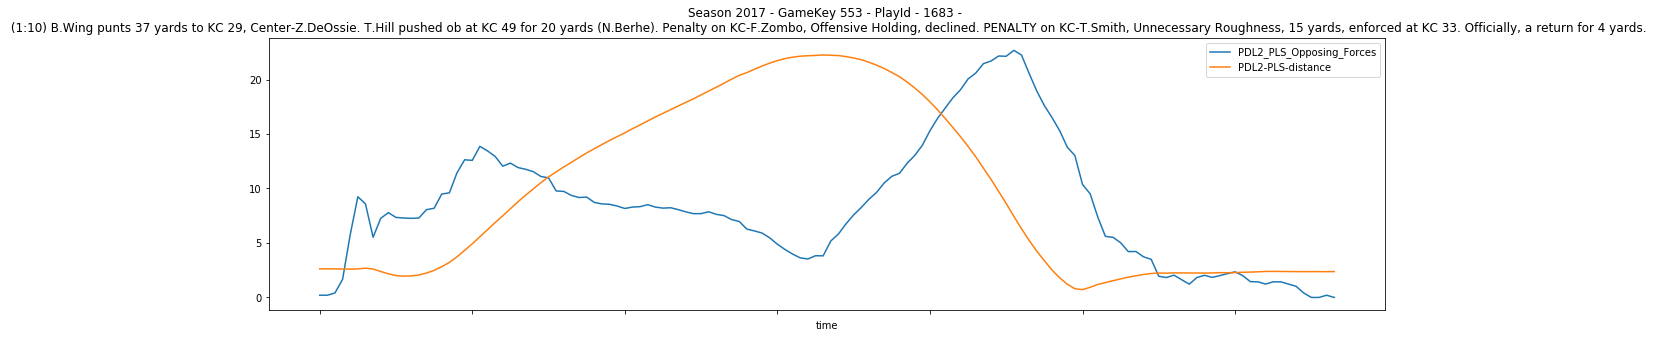

1407
Max opposing force: 
12.5679763056


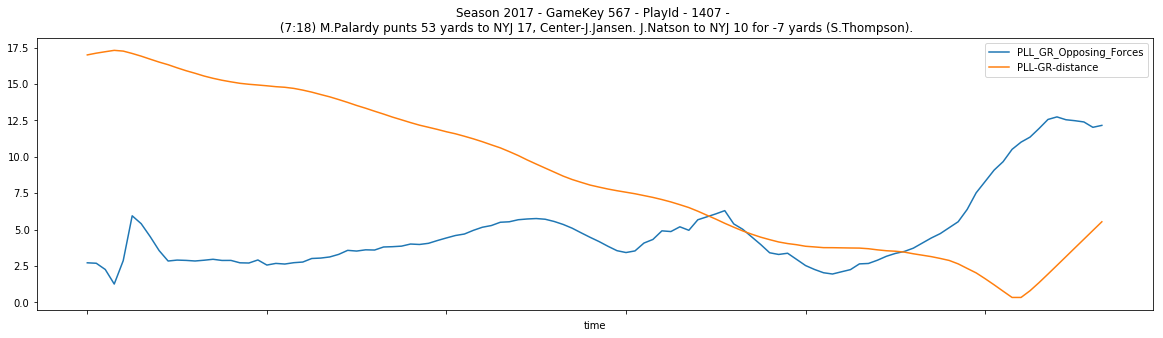

2208
Max opposing force: 
error
'x None'
602
Max opposing force: 
10.3273975096


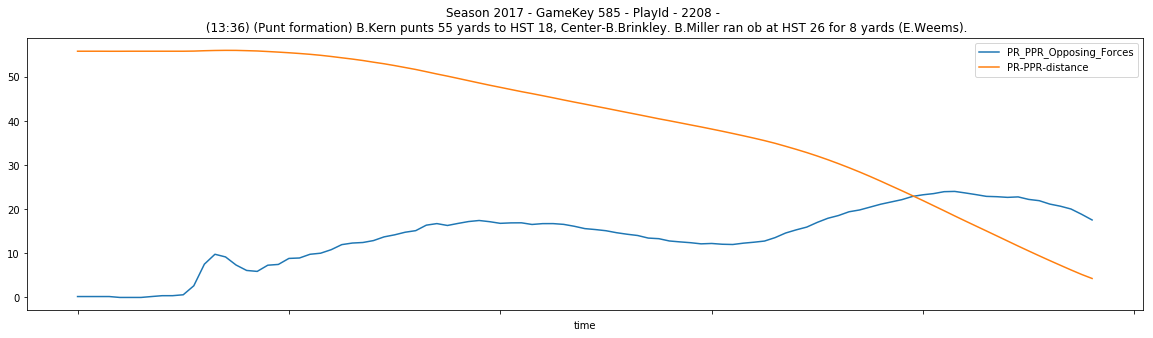

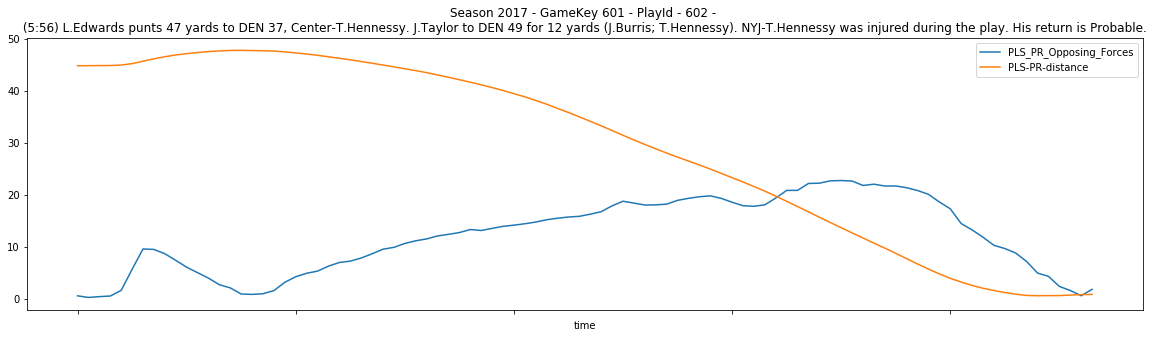

978
Max opposing force: 
5.73217774374


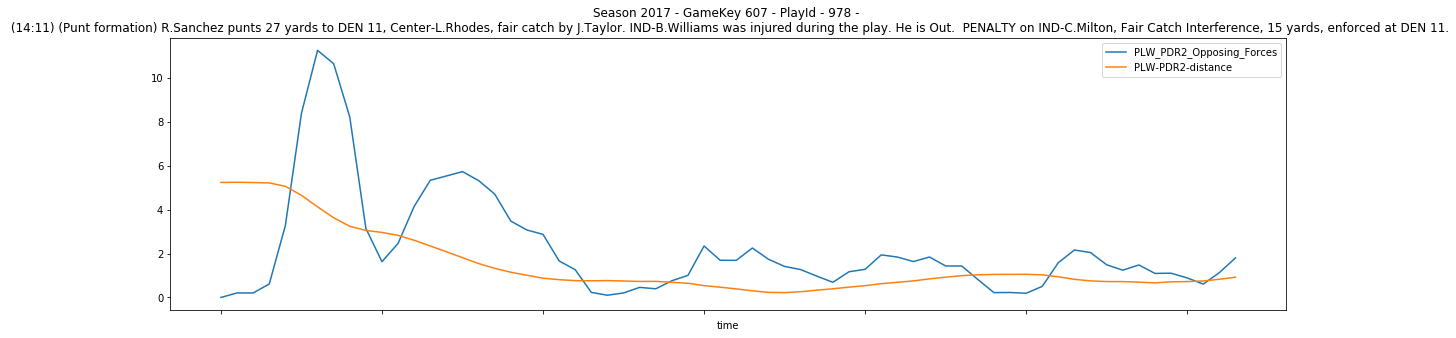

2792
Max opposing force: 
12.486750015


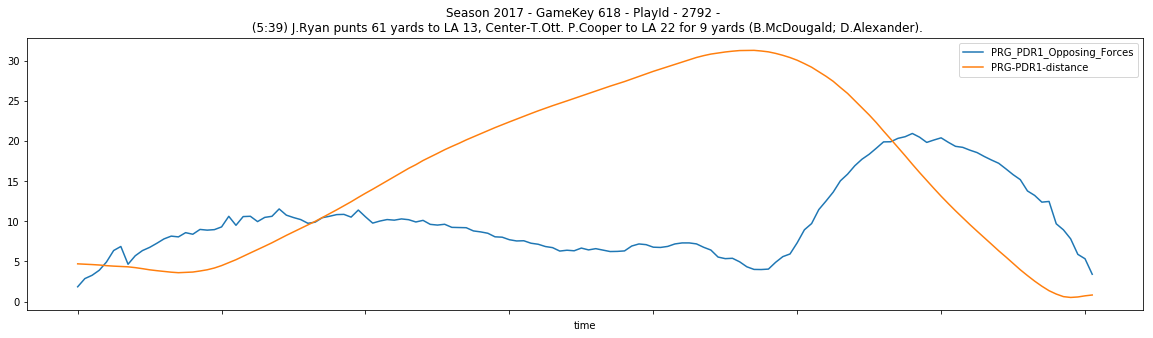

In [25]:
for row in vr_merged.iterrows():
    role1 = row[1]['Role_x']
    role2 = row[1]['Role_y']
    year = row[1]['Season_Year']
    gamekey = row[1]['GameKey']
    playid = row[1]['PlayID']
    try:
        df = plot_opposing_forces(year, gamekey, playid, role1, role2)
        print(playid)
        print('Max opposing force: ')
        if df.loc[df['{}-{}-distance'.format(role1, role2)] < 2]['{}_{}_Opposing_Forces'.format(role1, role2)].max() is not np.nan:
            print(df.loc[df['{}-{}-distance'.format(role1, role2)] < 2]['{}_{}_Opposing_Forces'.format(role1, role2)].max())
            plt.show()
    except Exception as e:
        print('error')
        print(e)

# Max opposing force for non-injury plays

In [32]:
df.loc[df['{}-{}-distance'.format(role1, role2)] < 2]['{}_{}_Opposing_Forces'.format(role1, role2)].max()

nan

error 2017 663 646
Index contains duplicate entries, cannot reshape
error 2017 663 955
Index contains duplicate entries, cannot reshape
1648
Max opposing force: 
9.80695141013


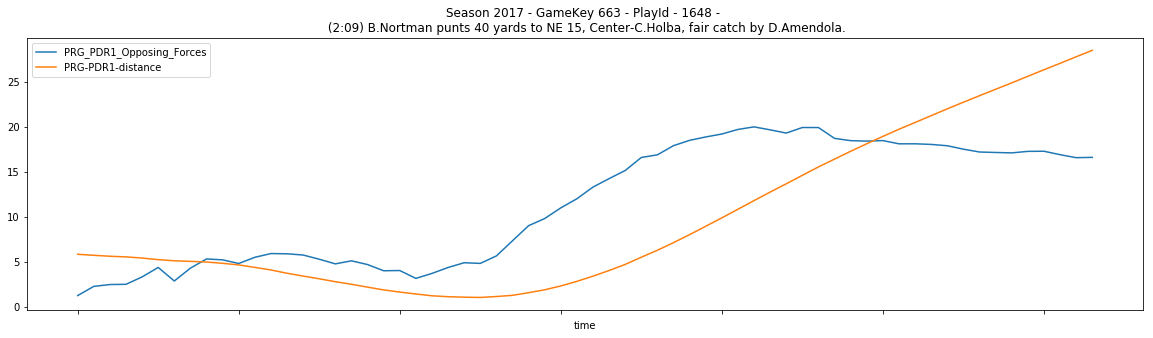

1766
Max opposing force: 
7.21922429888


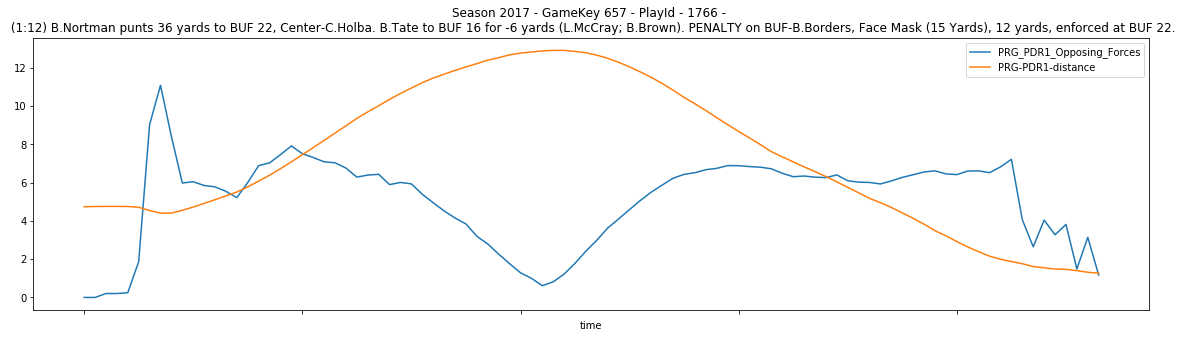

209
Max opposing force: 
10.7543014214


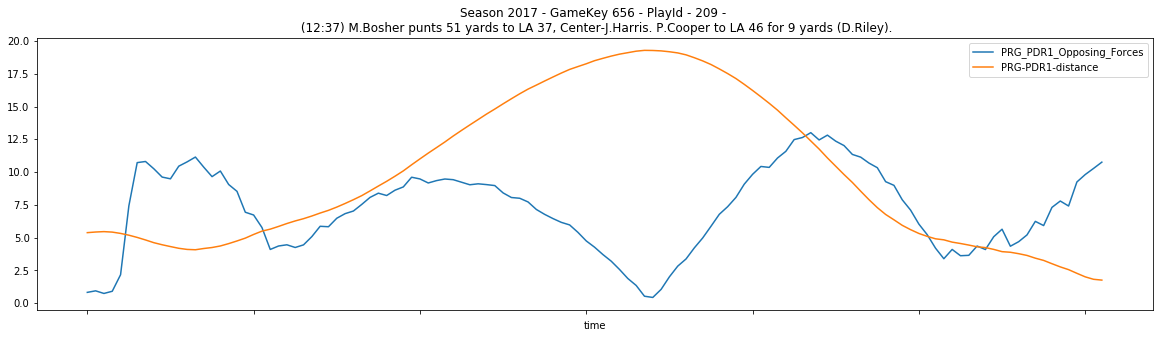

2580
Max opposing force: 
8.01525925668


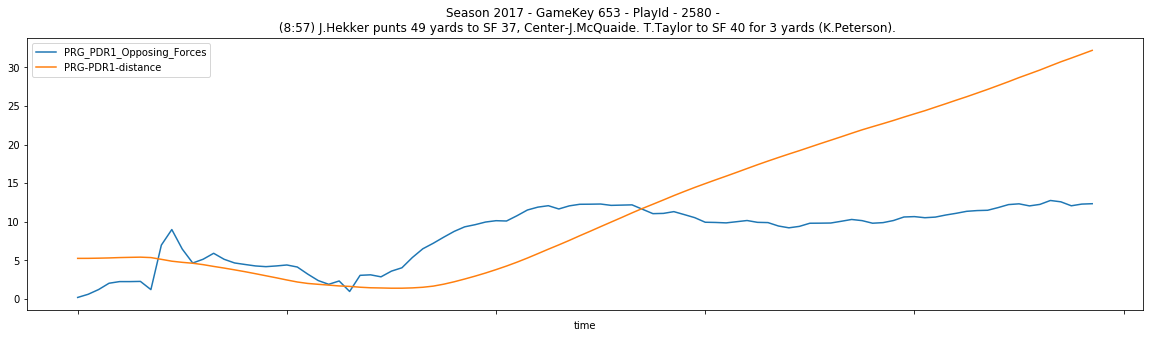

2278
Max opposing force: 
11.2956665068


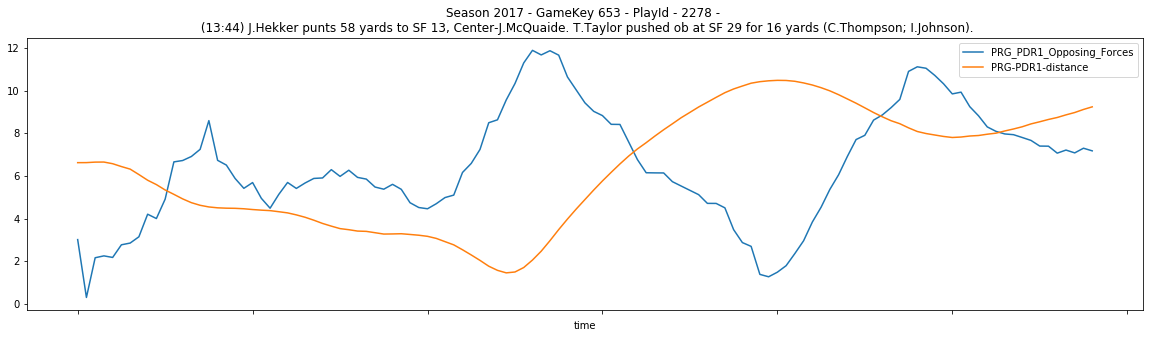

error 2017 652 588
Index contains duplicate entries, cannot reshape
error 2017 651 1980
Index contains duplicate entries, cannot reshape
1164
Max opposing force: 
3.66725508627


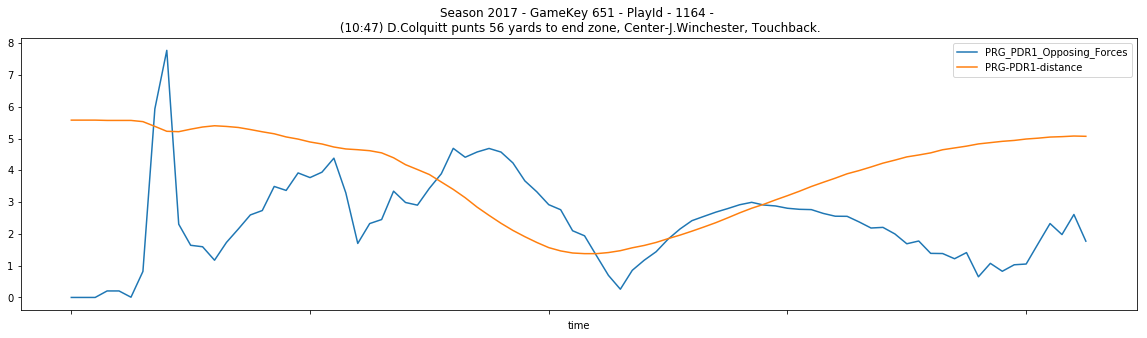

2832
Max opposing force: 
6.42203015633


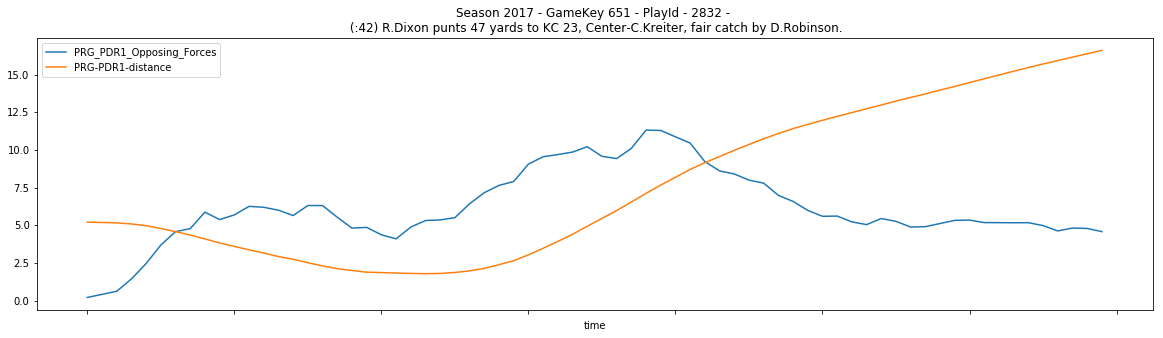

error 2017 650 585
Index contains duplicate entries, cannot reshape
3683
Max opposing force: 
6.47449843509


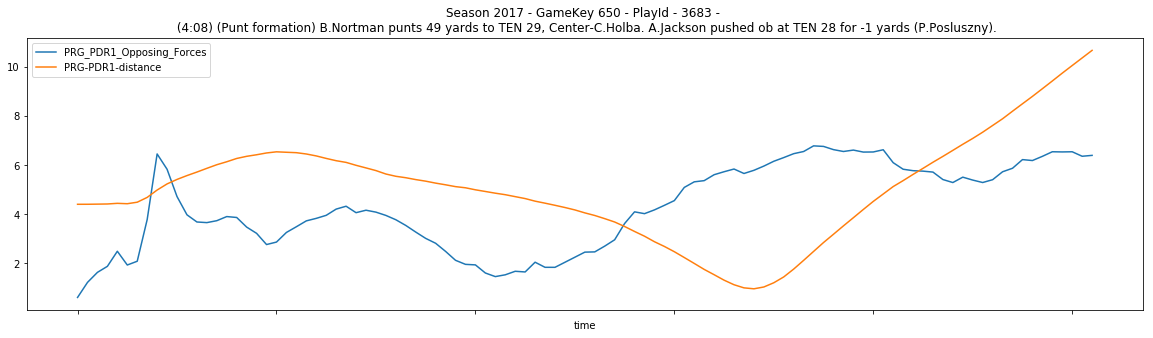

error 2017 647 1057
File b'../working/playlevel/during_play/2017-647-1057.csv' does not exist
2039
Max opposing force: 
10.54297602


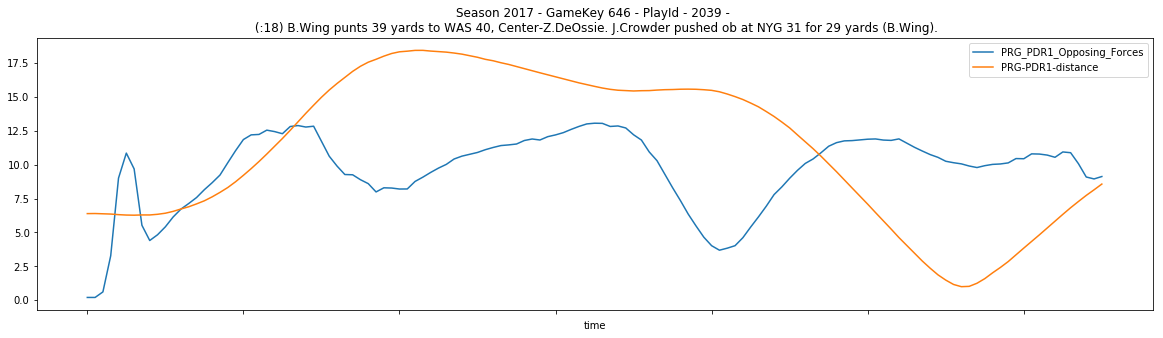

656
Max opposing force: 
6.18080392208


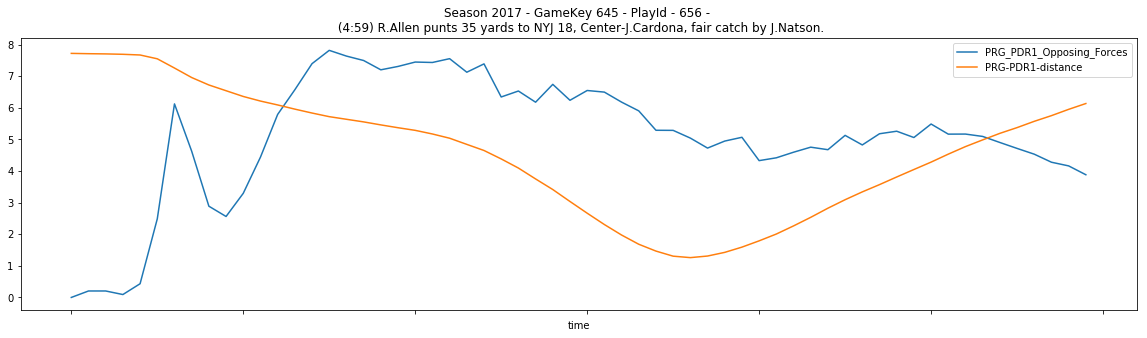

error 2017 645 2516
Index contains duplicate entries, cannot reshape
error 2017 645 3877
File b'../working/playlevel/during_play/2017-645-3877.csv' does not exist
438
Max opposing force: 
3.04326018734


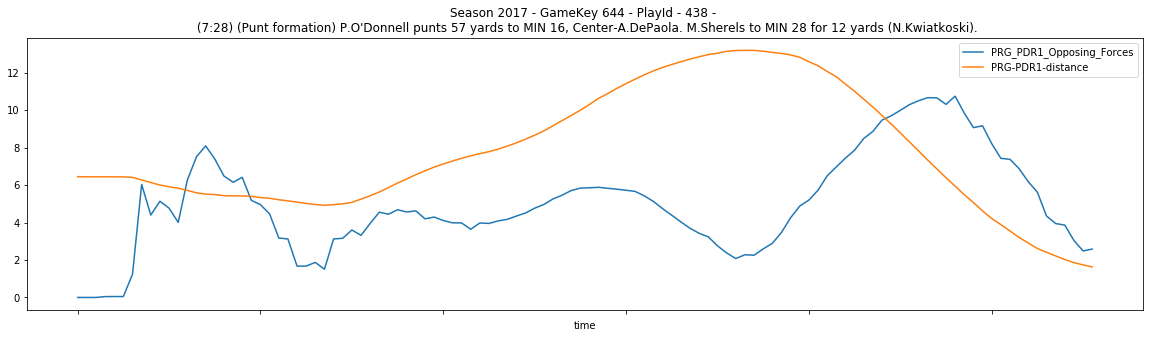

error 2017 644 1395
Index contains duplicate entries, cannot reshape
error 2017 639 1261
Index contains duplicate entries, cannot reshape
2203
Max opposing force: 
5.50330718431


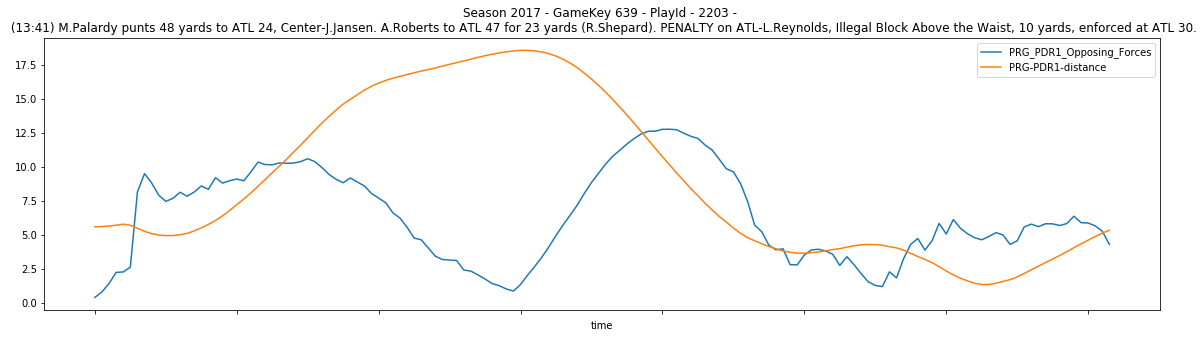

error 2017 638 908
Index contains duplicate entries, cannot reshape
error 2017 636 681
Index contains duplicate entries, cannot reshape
error 2017 634 2807
Index contains duplicate entries, cannot reshape
191
Max opposing force: 
6.1985432065


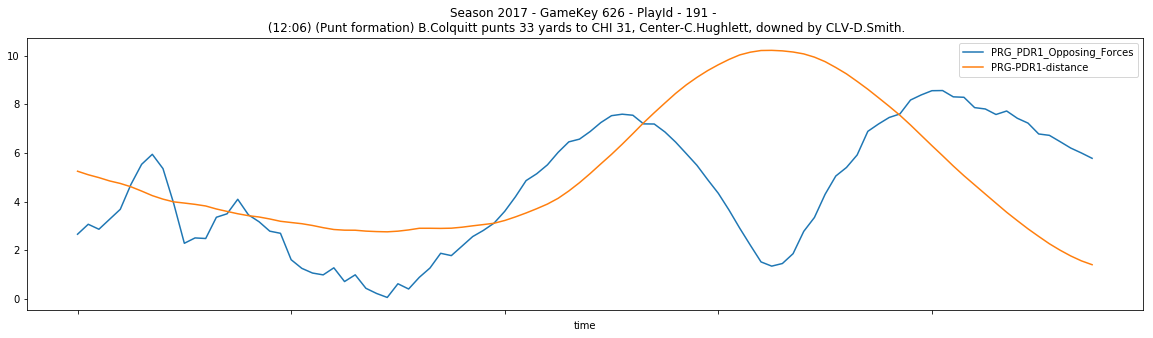

345
Max opposing force: 
10.207945257


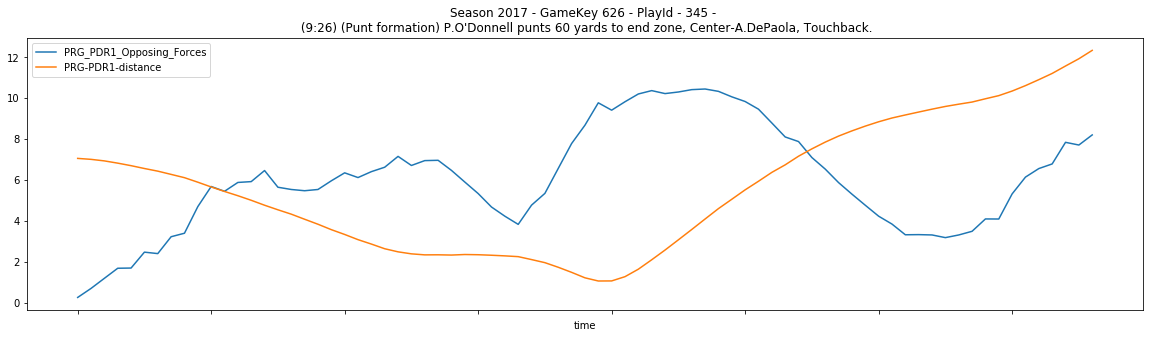

1829
Max opposing force: 
7.40931077659


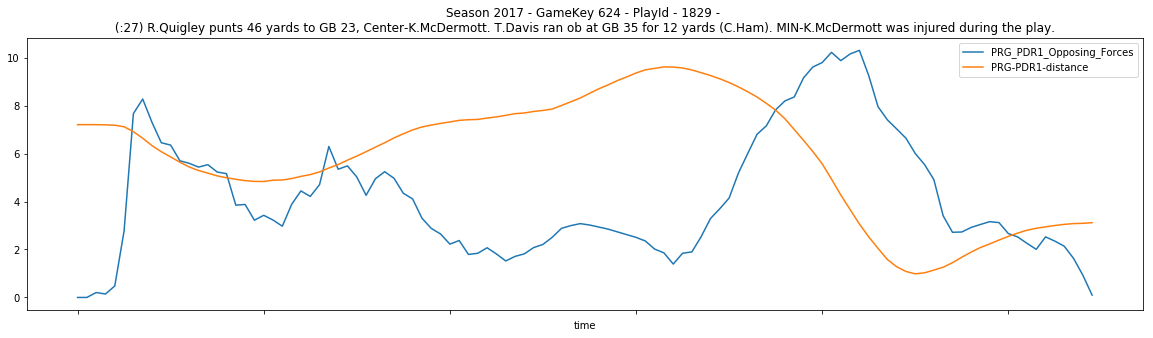

208
Max opposing force: 
6.93886697121


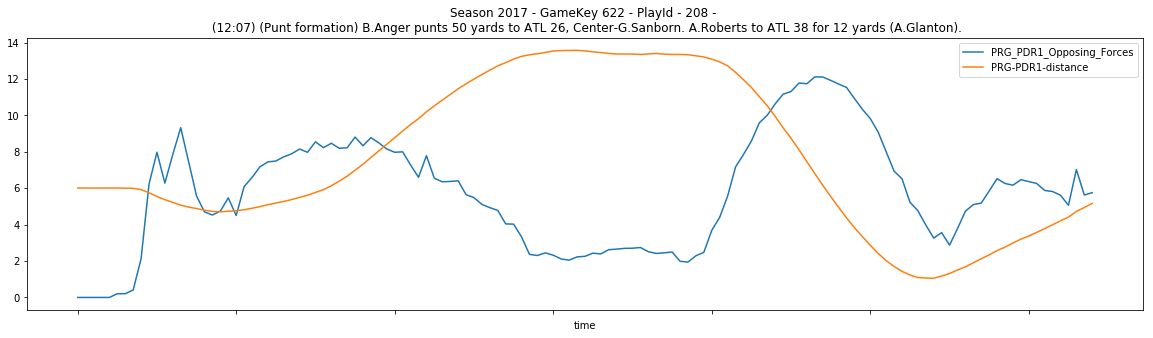

error 2017 621 3368
Index contains duplicate entries, cannot reshape
error 2017 621 2594
Index contains duplicate entries, cannot reshape
1022
Max opposing force: 
7.42940717595


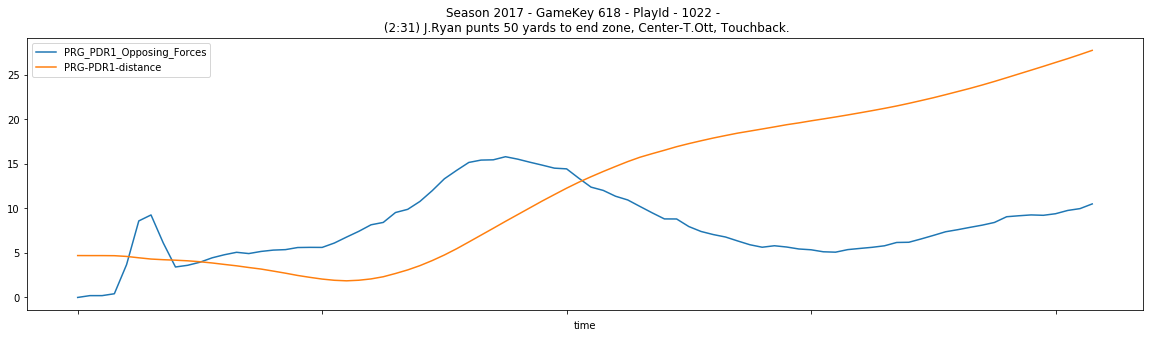

2792
Max opposing force: 
12.486750015


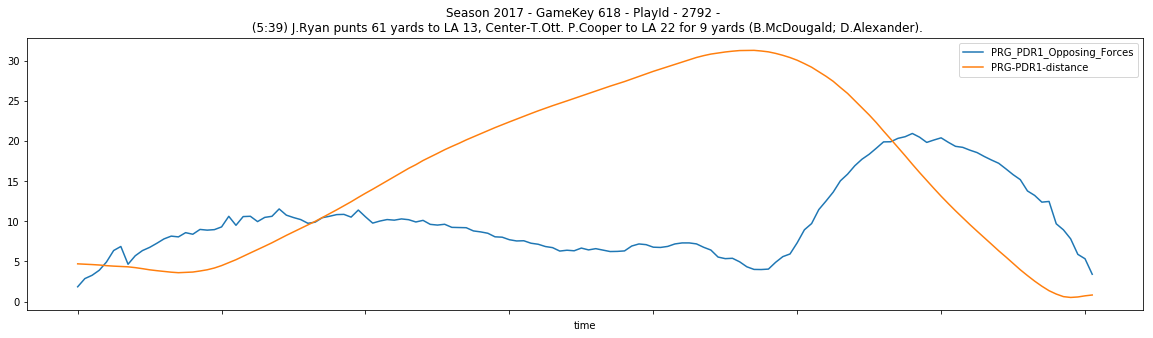

error 2017 618 4113
Index contains duplicate entries, cannot reshape
error 2017 618 4244
Index contains duplicate entries, cannot reshape


In [57]:
count = 1
for row in pi.sort_values('GameKey', ascending=False).iterrows():
    year = row[1]['Season_Year']
    gamekey = row[1]['GameKey']
    playid = row[1]['PlayID']
    role1 = 'PRG'
    role2 = 'PDR1'
    try:
        df = plot_opposing_forces(year, gamekey, playid, role1, role2, plot=False)
        if df.loc[df['{}-{}-distance'.format(role1, role2)] < 2]['{}_{}_Opposing_Forces'.format(role1, role2)].max() is not np.nan:
            print(playid)
            print('Max opposing force: ')
            print(df.loc[df['{}-{}-distance'.format(role1, role2)] < 2]['{}_{}_Opposing_Forces'.format(role1, role2)].max())
            df = plot_opposing_forces(year, gamekey, playid, role1, role2, plot=True)
            plt.show()
    except Exception as e:
        print('error {} {} {}'.format(year, gamekey, playid))
        print(e)
    count += 1
    if count == 500:
        break

In [66]:
play.dtypes

Unnamed: 0                            int64
season_year                           int64
gamekey                               int64
playid                                int64
gsisid                                int64
time                                 object
x                                   float64
y                                   float64
dis                                 float64
o                                   float64
dir                                 float64
event                                object
number                               object
position                             object
role                                 object
generalized_role                     object
punting_returning_team               object
gsisid_injured                      float64
player_activity_derived             float64
turnover_related                    float64
primary_impact_type                 float64
primary_partner_gsisid              float64
primary_partner_activity_derived

In [69]:
play.groupby(['role']).count()

,Unnamed: 0,season_year,gamekey,playid,gsisid,time,x,y,dis,o,...,first_contact,out_of_bounds,play_submit,punt,punt_received,mph,injured_player,primary_partner_player,left_to_right,xy
role,,,,,,,,,,,,,,,,,,,,,
GL,109,109,109,109,109,109,109,109,109,109,...,109,109,109,109,109,109,109,109,109,109
GR,109,109,109,109,109,109,109,109,109,109,...,109,109,109,109,109,109,109,109,109,109
P,109,109,109,109,109,109,109,109,109,109,...,109,109,109,109,109,109,109,109,109,109
PDL1,109,109,109,109,109,109,109,109,109,109,...,109,109,109,109,109,109,109,109,109,109
PDL2,109,109,109,109,109,109,109,109,109,109,...,109,109,109,109,109,109,109,109,109,109
PDR1,109,109,109,109,109,109,109,109,109,109,...,109,109,109,109,109,109,109,109,109,109
PDR2,109,109,109,109,109,109,109,109,109,109,...,109,109,109,109,109,109,109,109,109,109
PDR3,109,109,109,109,109,109,109,109,109,109,...,109,109,109,109,109,109,109,109,109,109
PLG,109,109,109,109,109,109,109,109,109,109,...,109,109,109,109,109,109,109,109,109,109


## Dealing with muliple players with the same position

In [ ]:
play.loc[play['time'] == 'test']

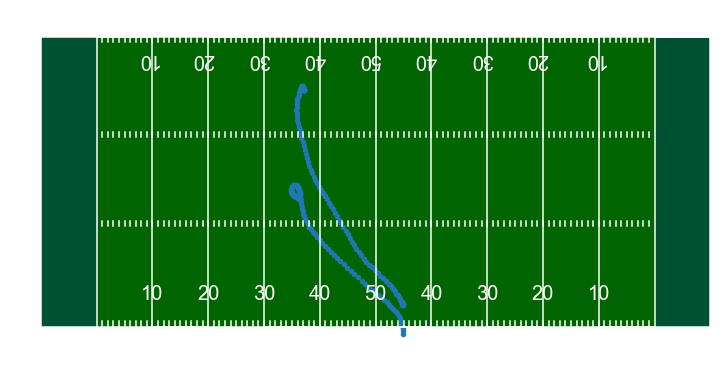

In [73]:
from football_field import create_football_field
fig, ax = create_football_field()
play.loc[play['role'] == 'PR'].plot(x='x',y='y', ax=ax, kind='scatter')

In [67]:
play =pd.read_csv('../working/playlevel/during_play/2017-618-4244.csv')
play['xy'] = play['x'].astype(str) + ',' + play['y'].astype(str)
play_pivoted = play.pivot(index='time', columns='gsisid', values=['xy','mph','dir', 'x', 'y'])
play_pivoted.columns = [' '.join(col).strip() for col in play_pivoted.columns.values]

TypeError: sequence item 1: expected str instance, int found

In [2]:
import pandas as pd
play = pd.read_csv('../working/playlevel/during_play/{}-{}-{}.csv'.format(2016,
                                                                       6,
                                                                      3725))

In [9]:
%load_ext autoreload
%autoreload 2

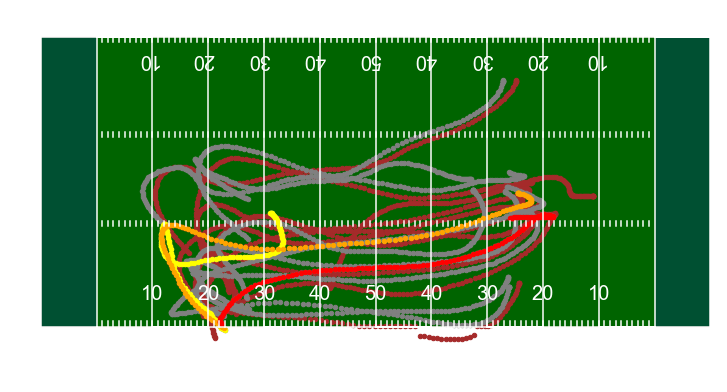

In [52]:
import sys
sys.path.insert(0, '../scripts/')
import plots
plots.plot_play(year=2017, gamekey=618, playid=2792, highlight_yellow='PR', highlight_orange='PRG', highlight_red='PDR1')

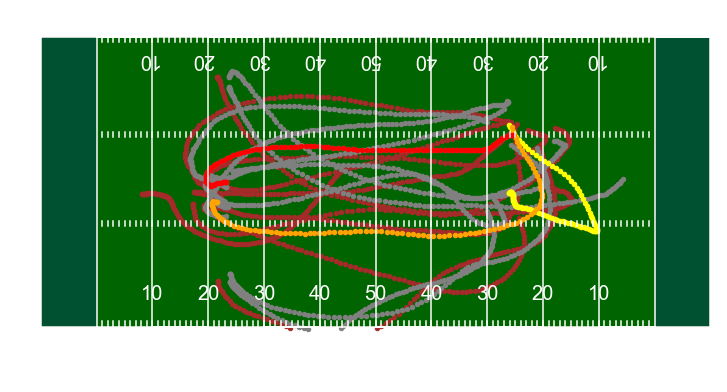

In [45]:
import sys
sys.path.insert(0, '../scripts/')
import plots
plots.plot_play(year=2016, gamekey=26, playid=731, highlight_yellow='PR', highlight_orange='PRG', highlight_red='PDR1')

In [48]:
play_info_row = pi.loc[(pi['Season_Year'] == year) &
   (pi['GameKey'] == gamekey) &
   (pi['PlayID'] == playid)]

In [56]:
play_info_row['PlayDescription'].values[0]

'(:31) L.Edwards punts 39 yards to NYG 18, Center-T.Purdum. D.Harris to NYG 28 for 10 yards (R.Miles).'